In [1]:
import time
import os
import random
import warnings
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import plotly.express as px
from data_cleaning import data_cleaning
from data_loader import FeatureExtractionDataLoader

test_size = 0.15
seed = 9
scoring = "accuracy"

## Selecting Dataset

We are doing hyperparameter tuning on a small dataset and then use the parameter on the whole dataset

Then we are going to extract the image features' of images and store in a .mat file.

**If you have the .mat file already, you can skip this part**

In [2]:
data_cleaning(False, True, force_write=True)

[STATUS] copying pics in data_set/self-collected/003_0_mato_sakura_official to data_set/modeling_data/mato_sakura
[STATUS] 003_0_mato_sakura_official copy work finished
[STATUS] copying pics in data_set/self-collected/009_1_jeanne_darc_official to data_set/modeling_data/jeanne_darc
[STATUS] 009_1_jeanne_darc_official copy work finished
[STATUS] copying pics in data_set/self-collected/004_0_illyasviel_von_einzbern_official to data_set/modeling_data/illyasviel_von_einzbern
[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set/self-collected/006_0_misaka_mikoto_official to data_set/modeling_data/misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set/self-collected/005_0_rider_medusa_official to data_set/modeling_data/rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set/self-collected/011_1_astolfo_official to data_set/modeling_data/astolfo
[STA

Extract the image features and store into a tf_s_dataset.mat

In [3]:
loader = FeatureExtractionDataLoader()
loader.write_data(file_name= "tf_s_dataset.mat", rgb=False)

[STATUS] Characters including ['violet_evergarden', 'tohsaka_rin', 'illyasviel_von_einzbern', 'jeanne_darc', 'mato_sakura', 'atalanta', 'misaka_mikoto', 'saber_arutoria_pendoragon', 'rider_medusa', 'astolfo', 'mordred']
[STATUS] 1/11 processing folder: violet_evergarden
[STATUS] 2/11 processing folder: tohsaka_rin
[STATUS] 3/11 processing folder: illyasviel_von_einzbern
[STATUS] 4/11 processing folder: jeanne_darc
[STATUS] 5/11 processing folder: mato_sakura
[STATUS] 6/11 processing folder: atalanta
[STATUS] 7/11 processing folder: misaka_mikoto
[STATUS] 8/11 processing folder: saber_arutoria_pendoragon
[STATUS] 9/11 processing folder: rider_medusa
[STATUS] 10/11 processing folder: astolfo
[STATUS] 11/11 processing folder: mordred
[STATUS] completed Feature Extraction.
[STATUS] feature vector shape: (1267, 532)
[STATUS] rgb vector shape: (0,)
[STATUS] label vector shape: (1267,)
[STATUS] training labels encoded.
[STATUS] save to data_set/tf_s_dataset.mat


### load saved data

In [4]:
data = sio.loadmat(os.path.join('data_set', 'tf_s_dataset.mat'))

### normalize data

In [5]:
warnings.filterwarnings('ignore')
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['image_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


### Train test split

In [6]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (1076, 532)
Test data    : (191, 532)
Train labels : (1076,)
Test labels  : (191,)


## Hyper parameter Tuning

### Logistic Regression:

1. Penalty Function

2. C

In [7]:
## Tuned result:
MAX_ITER = 10000 # tunned, no change after 100
TOL = 1e-4 # tunned, no change
C = 6.8 # tunned

In [8]:
# Penalty Function
list_p = ["l2", "none"]
list_c = np.linspace(1.5, 2.4, 10)

p_models = dict()

for i in list_p:
    p_models[i] = dict()
    for c in list_c:
        p_models[i][c] =  LogisticRegression(penalty=i, max_iter=MAX_ITER, random_state=seed,
                                             tol=TOL, C=c, warm_start=True)

p_results = {'l2': [], "none": []}
p_names = {'l2': [], "none": []}

for penalty in p_models:
    for name, model in p_models[penalty].items():
        since = time.time()
        kf = KFold(n_splits=4, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        p_results[penalty].append(cv_results)
        p_names[penalty].append(name)
        print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name,
                                                                                     cv_results.mean(),
                                                                                     cv_results.std()))
        time_elapsed = time.time() - since
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                                       time_elapsed % 60))

[CROSS_VAL_SCORE] Training 1.5 : accuracy: 0.738, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.6 : accuracy: 0.736, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.7 : accuracy: 0.738, std: 0.018
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.8 : accuracy: 0.740, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.9 : accuracy: 0.740, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.0 : accuracy: 0.742, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.1 : accuracy: 0.743, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.2 : accuracy: 0.743, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.3 : accuracy: 0.743, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 2.4 : accuracy: 0.743, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL

Visualization of Penalty function selection

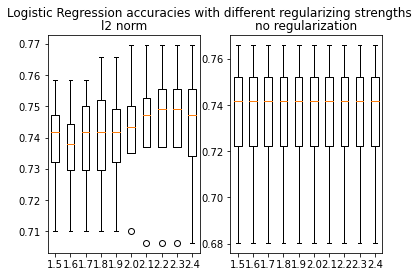

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Logistic Regression accuracies with different regularizing strengths')
ax1.boxplot(p_results['l2'])
ax1.set_xticklabels(p_names['l2'])
ax1.set_title("l2 norm")
ax2.boxplot(p_results['none'])
ax2.set_xticklabels(p_names['none'])
ax2.set_title("no regularization")
# plt.savefig("project_document/images/log_reg_hyperparam_penalty", dpi=500)
plt.show()

tuning: regulization strength C

In [10]:
list_i = np.linspace(.1, 10., 100)

c_models = {i: LogisticRegression(max_iter=MAX_ITER, random_state=seed, tol=TOL, C=i, warm_start=True)
            for i in np.linspace(.1, 10, 100)}

results = []
names = []

for name in c_models:
    since = time.time()
    model = c_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training 0.1 : accuracy: 0.612, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.2 : accuracy: 0.674, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.30000000000000004 : accuracy: 0.700, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.4 : accuracy: 0.711, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.5 : accuracy: 0.720, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.6 : accuracy: 0.721, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 0.7000000000000001 : accuracy: 0.722, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.8 : accuracy: 0.729, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 0.9 : accuracy: 0.731, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 1.0 : accuracy: 0.733, std: 0.024
[TIME_CONSUMPTION

[CROSS_VAL_SCORE] Training 8.1 : accuracy: 0.762, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.2 : accuracy: 0.762, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.3 : accuracy: 0.761, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.4 : accuracy: 0.761, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.5 : accuracy: 0.761, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.6 : accuracy: 0.761, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.7 : accuracy: 0.760, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.8 : accuracy: 0.760, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 8.9 : accuracy: 0.760, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training 9.0 : accuracy: 0.761, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL

visualization of regulization strength C

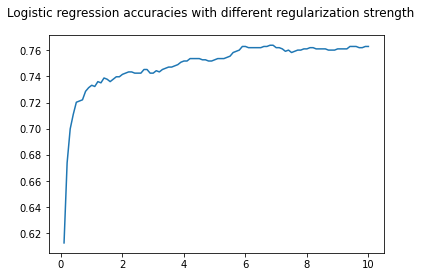

Best regularization strength C = 6.8, accuracy = 0.7639405204460966


In [11]:
fig = plt.figure()
# fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.xticks(rotation=-45)
# plt.show()

accuracies = [r.mean() for r in results]
fig.suptitle("Logistic regression accuracies with different regularization strength")
plt.plot(list_i, accuracies)
# plt.savefig("project_document/images/log_reg_hyperparam_c", dpi=500)
plt.show()
print("Best regularization strength C = {}, accuracy = {}"
      .format(list_i[np.array(accuracies).argmax()], np.array(accuracies).max()))

### KNN hyperparameter tunning

turning: K

In [12]:
list_i = range(2, 30)

k_models = {k: KNeighborsClassifier(n_neighbors=k) for k in list_i}

results = []
names = []

for name in k_models:
    since = time.time()
    model = k_models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

[CROSS_VAL_SCORE] Training 2 : accuracy: 0.673, std: 0.017
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 3 : accuracy: 0.659, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 4 : accuracy: 0.674, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 5 : accuracy: 0.660, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 6 : accuracy: 0.666, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 7 : accuracy: 0.654, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 8 : accuracy: 0.653, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 9 : accuracy: 0.648, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 10 : accuracy: 0.646, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 11 : accuracy: 0.636, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training 1

visualization of K tuning

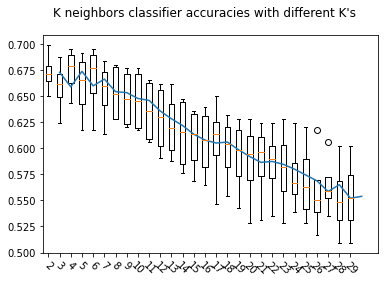

Best k = 4, accuracy = 0.6737918215613383


In [13]:
fig = plt.figure()
fig.suptitle('K neighbors classifier accuracies with different K\'s')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=-45)
# plt.show()

accuracies = [r.mean() for r in results]
plt.plot(list_i, accuracies)
# plt.savefig("project_document/images/knn_k", dpi=500)
plt.show()
print("Best k = {}, accuracy = {}"
      .format(list_i[np.array(accuracies).argmax()], np.array(accuracies).max()))

### Random Forest

1. Error function
2. n_estimators

Tuning error function:

In [14]:
rf_gini_acc = []
rf_gini_time_list = []
rf_entropy_acc = []
rf_entropy_time_list = []
rf_loss_f_n_list = np.hstack([np.array([10,50,100,500]),np.linspace(600,1500,num=5)])
for n in rf_loss_f_n_list:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training gini, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_gini_time_list.append(time_elapsed)
    rf_gini_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='entropy')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training entropy, n_estimators: {}, accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    rf_entropy_time_list.append(time_elapsed)
    rf_entropy_acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training gini, n_estimators: 10.0, accuracy: 0.715, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 10.0, accuracy: 0.696, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training gini, n_estimators: 50.0, accuracy: 0.813, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 50.0, accuracy: 0.814, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training gini, n_estimators: 100.0, accuracy: 0.830, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 100.0, accuracy: 0.828, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training gini, n_estimators: 500.0, accuracy: 0.835, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training entropy, n_estimators: 500.0, accuracy: 0.828, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 8s
[CROSS_VAL_SCORE] Training gini,

visualization of error function tunning

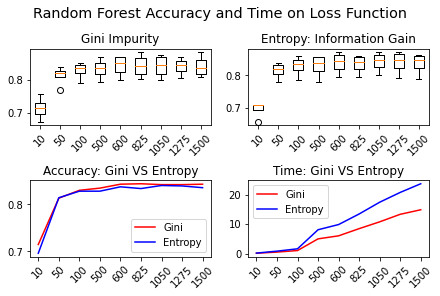

In [15]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(6, 2)
fig.suptitle('Random Forest Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0:3,0])
plt.boxplot(rf_gini_acc)
ax1.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Gini Impurity')
plt.xticks(rotation=45, horizontalalignment="center")

ax2 = fig.add_subplot(gs[0:3,1 ])
plt.boxplot(rf_entropy_acc)
ax2.set_xticklabels([int(x) for x in rf_loss_f_n_list])
plt.title('Entropy: Information Gain')
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,0])
plt.title('Accuracy: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_gini_acc], c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], [x.mean() for x in rf_entropy_acc], c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")

ax3 = fig.add_subplot(gs[3:6,1])
plt.title('Time: Gini VS Entropy')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_gini_time_list, c='r', label='Gini')
plt.plot([str(int(x)) for x in rf_loss_f_n_list], rf_entropy_time_list, c='b', label='Entropy')
plt.legend()
plt.xticks(rotation=45, horizontalalignment="center")
# plt.savefig("project_document/images/rand_forest_loss_func", dpi=500)
plt.show()

tunning number of trees: n_estimators

In [16]:
acc = []
time_list = []
n_list_2 = np.hstack([np.array([10,50,100,500]),np.linspace(600,1400,num=5),np.array([3000,5000])])
for n in n_list_2:
    since = time.time()
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    model = RandomForestClassifier(n_estimators = int(n), criterion='gini')
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    print("[CROSS_VAL_SCORE] Training n_estimators: {} : accuracy: {:.3f}, std: {:.3f}".format(n, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    time_list.append(time_elapsed)
    acc.append(cv_results)
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


[CROSS_VAL_SCORE] Training n_estimators: 10.0 : accuracy: 0.752, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training n_estimators: 50.0 : accuracy: 0.814, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training n_estimators: 100.0 : accuracy: 0.835, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training n_estimators: 500.0 : accuracy: 0.836, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 5s
[CROSS_VAL_SCORE] Training n_estimators: 600.0 : accuracy: 0.839, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 6s
[CROSS_VAL_SCORE] Training n_estimators: 800.0 : accuracy: 0.845, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 8s
[CROSS_VAL_SCORE] Training n_estimators: 1000.0 : accuracy: 0.842, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 10s
[CROSS_VAL_SCORE] Training n_estimators: 1200.0 : accuracy: 0.843, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 12s
[CROSS_VAL_SCORE] Training n_estimators: 1400.0 : accuracy: 0.847, std: 0.028


visualzation of n_estimators

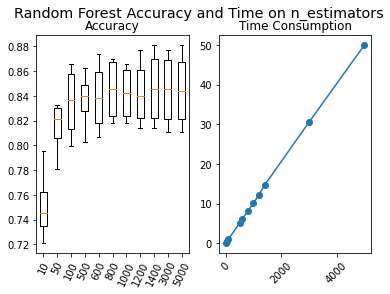

In [17]:
fig = plt.figure()
fig.suptitle("Random Forest Accuracy and Time on n_estimators", fontsize='x-large')
ax = fig.add_subplot(121)
plt.boxplot(acc)
ax.set_xticklabels([int(x) for x in n_list_2])
plt.xticks(rotation=65, horizontalalignment="center")
plt.title('Accuracy')
ax = fig.add_subplot(1,2,2)
ax.plot([int(x) for x in n_list_2], time_list)
ax.scatter([int(x) for x in n_list_2], time_list)
plt.xticks(rotation=45, horizontalalignment="center")
plt.title('Time Consumption')
# plt.savefig("project_document/images/rand_forest_n_estimators", dpi=500)
plt.show()

### SVM
1. Loss Function
2. C
3. poly degree

Tunning: loss function

In [18]:
svm_ker_acc = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_time_list = {'linear': [],
      'poly': [],
      'rbf': [],
      'sigmoid': []}
svm_ker_n_list = np.hstack([np.linspace(1,5,5),8,10,20,50,100])
for c in svm_ker_n_list:
    for ker in ["linear", "poly", 'rbf', 'sigmoid']:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel=ker, C=c, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(ker,c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_ker_time_list[ker].append(time_elapsed)
        svm_ker_acc[ker].append(cv_results)
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: linear, C = 1.0, accuracy: 0.756, std: 0.022
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 1.0, accuracy: 0.736, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 1.0, accuracy: 0.728, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 1.0, accuracy: 0.582, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: linear, C = 2.0, accuracy: 0.768, std: 0.041
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly, C = 2.0, accuracy: 0.763, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: rbf, C = 2.0, accuracy: 0.764, std: 0.042
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: sigmoid, C = 2.0, accuracy: 0.686, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: linear, C = 3.0, accuracy: 0.

Visualization of loss function tunning

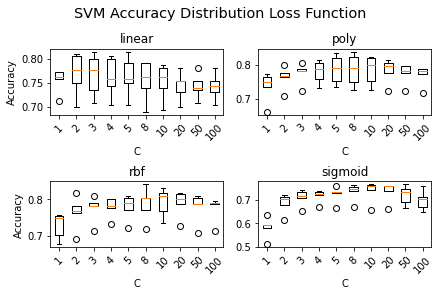

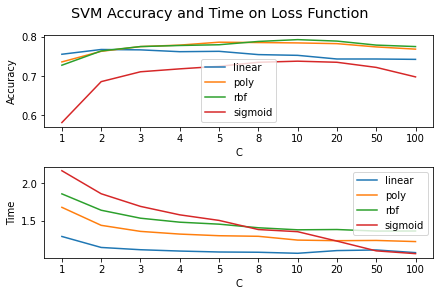

In [19]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
fig.suptitle('SVM Accuracy Distribution Loss Function', fontsize='x-large')

for i, key in enumerate(svm_ker_acc.keys()):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    plt.boxplot(svm_ker_acc[key])
    ax.set_xticklabels([int(x) for x in svm_ker_n_list])
    if i%2 == 0:
        plt.ylabel('Accuracy')
    plt.xlabel('C')
    plt.title(key)
    plt.xticks(rotation=45, horizontalalignment="center")

plt.show()



fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(ncols=1, nrows=2)
fig.suptitle('SVM Accuracy and Time on Loss Function', fontsize='x-large')

ax1 = fig.add_subplot(gs[0,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax1.plot([str(int(x)) for x in svm_ker_n_list], [x.mean() for x in svm_ker_acc[key]], label=key)
plt.ylabel('Accuracy')
plt.xlabel('C')
ax1.legend()

ax2 = fig.add_subplot(gs[1,:])
for i, key in enumerate(svm_ker_acc.keys()):
    ax2.plot([str(int(x)) for x in svm_ker_n_list], svm_ker_time_list[key], label=key)
plt.ylabel('Time')
plt.xlabel('C')
ax2.legend()
# plt.savefig("project_document/images/svm_kernel", dpi=500)
plt.show()

## Use poly

Selected polynomial penalty function.

tunning degree and regularizaion strength C:

In [20]:
# C of poly
# degree for poly
svm_c_list = np.linspace(1,30,30)
svm_degree_list = range(1,21)
svm_shape = (len(svm_c_list), len(svm_degree_list))
svm_acc = pd.DataFrame(np.zeros(svm_shape))
svm_acc.columns = svm_degree_list
svm_acc.index = svm_c_list
svm_time = pd.DataFrame(np.zeros(svm_shape))
svm_time.columns = svm_degree_list
svm_time.index = svm_c_list

for degree in svm_degree_list:
    for c in svm_c_list:
        since = time.time()
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        model = SVC(random_state=seed, kernel='poly', C=c, degree=degree, decision_function_shape='ovo')
        cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
        print("[CROSS_VAL_SCORE] Training kernal: poly,degree = {}, C = {}, accuracy: {:.3f}, std: {:.3f}".format(degree, c, cv_results.mean(), cv_results.std()))
        time_elapsed = time.time() - since
        svm_acc.loc[c, degree] = cv_results.mean()
        svm_time.loc[c, degree] = time_elapsed
        print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 1.0, accuracy: 0.672, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 2.0, accuracy: 0.722, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 3.0, accuracy: 0.746, std: 0.043
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 4.0, accuracy: 0.747, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 5.0, accuracy: 0.750, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 6.0, accuracy: 0.751, std: 0.024
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 7.0, accuracy: 0.757, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 1, C = 8.0, accuracy: 0.758, std: 0.021
[TIME_CONSUMPTION] Fin

[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 6.0, accuracy: 0.785, std: 0.040
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 7.0, accuracy: 0.783, std: 0.046
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 8.0, accuracy: 0.785, std: 0.042
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 9.0, accuracy: 0.784, std: 0.039
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 10.0, accuracy: 0.784, std: 0.038
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 11.0, accuracy: 0.786, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 12.0, accuracy: 0.784, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 3, C = 13.0, accuracy: 0.785, std: 0.035
[TIME_CONSUMPTION]

[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 11.0, accuracy: 0.788, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 12.0, accuracy: 0.789, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 13.0, accuracy: 0.789, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 14.0, accuracy: 0.787, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 15.0, accuracy: 0.786, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 16.0, accuracy: 0.789, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 17.0, accuracy: 0.789, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 5, C = 18.0, accuracy: 0.791, std: 0.030
[TIME_CONSUMPT

[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 16.0, accuracy: 0.784, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 17.0, accuracy: 0.783, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 18.0, accuracy: 0.783, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 19.0, accuracy: 0.786, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 20.0, accuracy: 0.787, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 21.0, accuracy: 0.787, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 22.0, accuracy: 0.786, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 7, C = 23.0, accuracy: 0.786, std: 0.032
[TIME_CONSUMPT

[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 21.0, accuracy: 0.772, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 22.0, accuracy: 0.772, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 23.0, accuracy: 0.773, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 24.0, accuracy: 0.772, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 25.0, accuracy: 0.774, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 26.0, accuracy: 0.774, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 27.0, accuracy: 0.775, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 9, C = 28.0, accuracy: 0.775, std: 0.029
[TIME_CONSUMPT

[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 25.0, accuracy: 0.762, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 26.0, accuracy: 0.762, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 27.0, accuracy: 0.762, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 28.0, accuracy: 0.762, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 29.0, accuracy: 0.762, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 11, C = 30.0, accuracy: 0.762, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 12, C = 1.0, accuracy: 0.665, std: 0.020
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 12, C = 2.0, accuracy: 0.711, std: 0.032
[TIME_CO

[CROSS_VAL_SCORE] Training kernal: poly,degree = 13, C = 29.0, accuracy: 0.743, std: 0.036
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 13, C = 30.0, accuracy: 0.742, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 1.0, accuracy: 0.618, std: 0.015
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 2.0, accuracy: 0.679, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 3.0, accuracy: 0.699, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 4.0, accuracy: 0.707, std: 0.034
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 5.0, accuracy: 0.717, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 14, C = 6.0, accuracy: 0.718, std: 0.029
[TIME_CONSUM

[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 3.0, accuracy: 0.655, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 4.0, accuracy: 0.672, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 5.0, accuracy: 0.684, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 6.0, accuracy: 0.691, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 7.0, accuracy: 0.699, std: 0.026
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 8.0, accuracy: 0.705, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 9.0, accuracy: 0.705, std: 0.028
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 16, C = 10.0, accuracy: 0.708, std: 0.030
[TIME_CONSUMP

[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 7.0, accuracy: 0.674, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 8.0, accuracy: 0.677, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 9.0, accuracy: 0.685, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 10.0, accuracy: 0.691, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 11.0, accuracy: 0.693, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 12.0, accuracy: 0.691, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 13.0, accuracy: 0.690, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 18, C = 14.0, accuracy: 0.690, std: 0.030
[TIME_CON

[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 11.0, accuracy: 0.665, std: 0.027
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 12.0, accuracy: 0.667, std: 0.029
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 13.0, accuracy: 0.670, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 14.0, accuracy: 0.672, std: 0.035
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 15.0, accuracy: 0.668, std: 0.032
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 16.0, accuracy: 0.671, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 17.0, accuracy: 0.669, std: 0.033
[TIME_CONSUMPTION] Finishing in 0m 2s
[CROSS_VAL_SCORE] Training kernal: poly,degree = 20, C = 18.0, accuracy: 0.673, std: 0.032
[TIME_

visualziation of c and degree

In [21]:
x_acc = []
y_acc = []
z_acc = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_acc.append(degree)
        y_acc.append(c)
        z_acc.append(svm_acc.loc[c, degree])
# z_acc_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_acc)))
x_time = []
y_time = []
z_time = []
for degree in svm_degree_list:
    for c in svm_c_list:
        x_time.append(degree)
        y_time.append(c)
        z_time.append(svm_time.loc[c, degree])
# z_time_sigmoid = 1 / (1 + np.exp(-1 * np.array(z_time)))

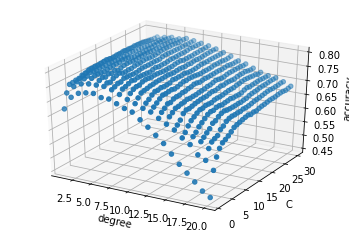

Best accuracy = 0.792, with degree = 4, C = 13.0


In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_acc, y_acc, z_acc, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('accuracy')
plt.show()
print("Best accuracy = {:.03f}, with degree = {}, C = {}"
      .format(np.max(z_acc), x_acc[np.argmax(z_acc)], y_acc[np.argmax(z_acc)]))

In [23]:
df_acc = pd.DataFrame({
    'degree': x_acc,
    'C': y_acc,
    'accuracy': z_acc
})
fig = px.scatter_3d(df_acc, x='degree', y='C', z='accuracy', color='accuracy', size='accuracy', size_max=13)
fig.show()

visualization of run time related to c and degree tunning

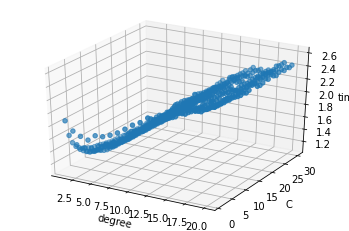

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_time, y_time, z_time, marker='o')
ax.set_xlabel('degree')
ax.set_ylabel('C')
ax.set_zlabel('time')
# plt.savefig("", dpi=500)
plt.show()

In [25]:
df_time = pd.DataFrame({
    'degree': x_time,
    'C': y_time,
    'time': z_time
})
fig = px.scatter_3d(df_time, x='degree', y='C', z='time', color='time', size_max=13)
fig.show()

In [26]:
i = np.array(z_acc).argmax()
svm_c = y_acc[i]
svm_degree = x_acc[i]

print("C = {}, degree = {}".format(svm_c, svm_degree))

C = 13.0, degree = 4


In [28]:
# Logistic Regreession
lr_c = 6.8
# Knn
knn_k = 4
# rf
num_trees = 1400
# svm
svm_c = 13.0
svm_degree = 4

[CROSS_VAL_SCORE] Training LR : accuracy: 0.754, std: 0.031
[TIME_CONSUMPTION] Finishing in 0m 1s
[CROSS_VAL_SCORE] Training LDA : accuracy: 0.553, std: 0.055
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training KNN : accuracy: 0.666, std: 0.030
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training CART : accuracy: 0.632, std: 0.021
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training RF : accuracy: 0.836, std: 0.025
[TIME_CONSUMPTION] Finishing in 0m 14s
[CROSS_VAL_SCORE] Training NB : accuracy: 0.436, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 0s
[CROSS_VAL_SCORE] Training SVM : accuracy: 0.778, std: 0.023
[TIME_CONSUMPTION] Finishing in 0m 1s


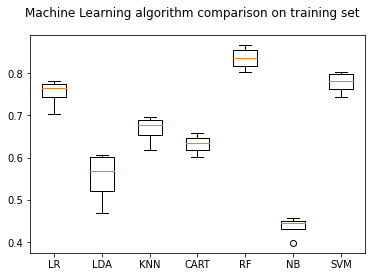

In [29]:
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=4.5, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_neighbors = 6),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion='gini', warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed, kernel='poly', C=svm_c, degree=svm_degree)}

results = []
names = []

for name in models.keys():
    since = time.time()
    model = models[name]
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, fv_trn, fv_l_trn, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("[CROSS_VAL_SCORE] Training {} : accuracy: {:.3f}, std: {:.3f}".format(name, cv_results.mean(), cv_results.std()))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison on training set')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
# plt.savefig("trad_comp", dpi=500)
plt.show()

### Train the models and see the accuracy rate on both training and testing set

In [30]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 0.930
[RESULT] LR accuracy on testing set: 0.754
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] LDA accuracy on training set: 0.943
[RESULT] LDA accuracy on testing set: 0.581
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] KNN accuracy on training set: 0.785
[RESULT] KNN accuracy on testing set: 0.723
[TIME_CONSUMPTION] Finishing in 0m 1s
[RESULT] CART accuracy on training set: 1.000
[RESULT] CART accuracy on testing set: 0.639
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] RF accuracy on training set: 1.000
[RESULT] RF accuracy on testing set: 0.817
[TIME_CONSUMPTION] Finishing in 0m 5s
[RESULT] NB accuracy on training set: 0.632
[RESULT] NB accuracy on testing set: 0.476
[TIME_CONSUMPTION] Finishing in 0m 0s
[RESULT] SVM accuracy on training set: 0.989
[RESULT] SVM accuracy on testing set: 0.780
[TIME_CONSUMPTION] Finishing in 0m 1s


### Best model: Random Froest
We build some examples using random forest model.

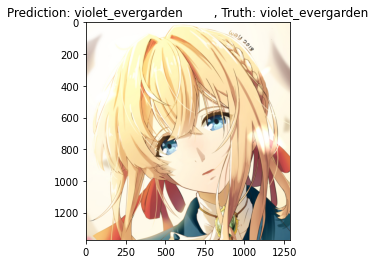

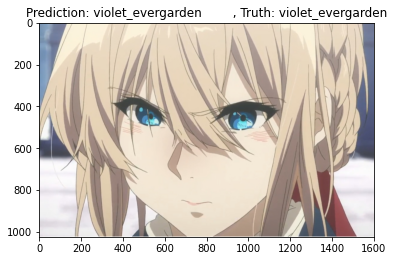

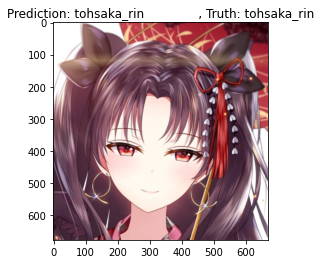

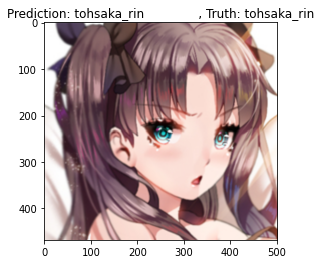

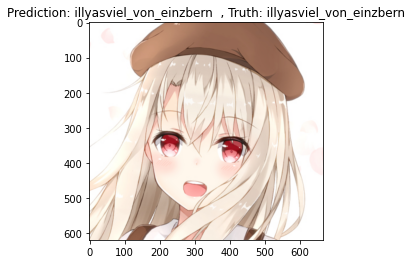

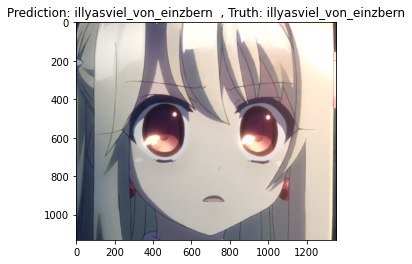

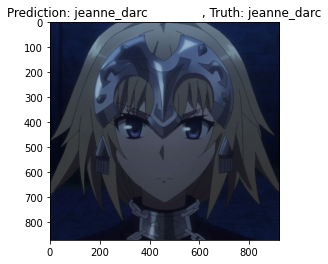

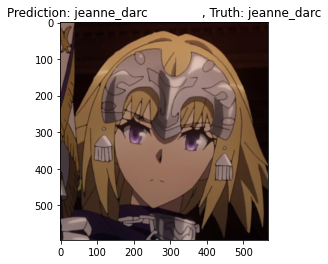

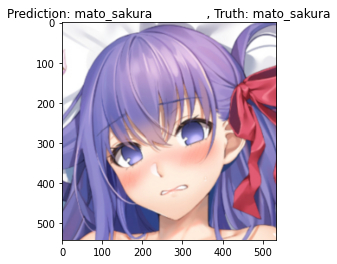

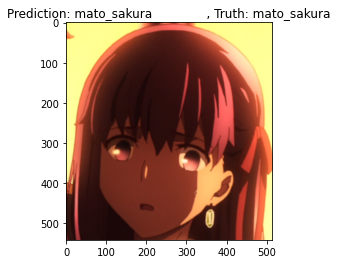

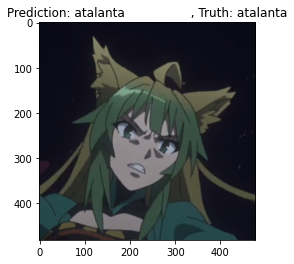

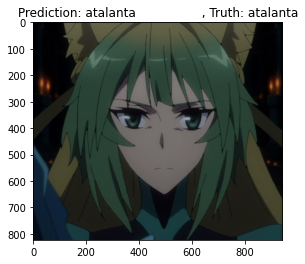

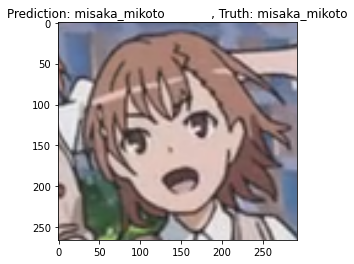

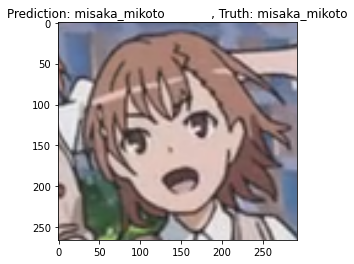

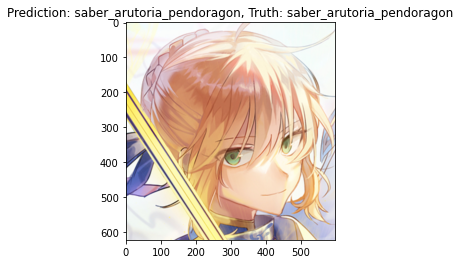

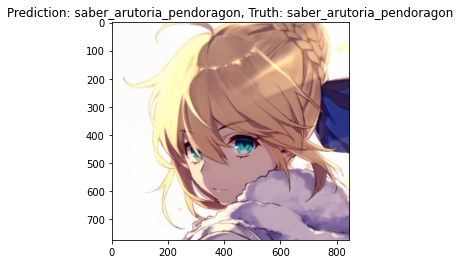

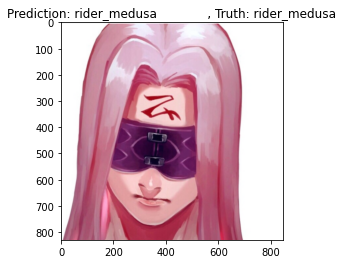

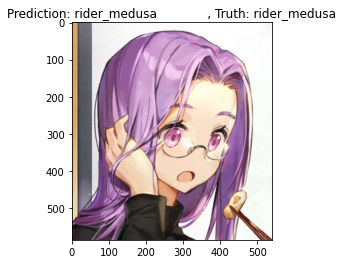

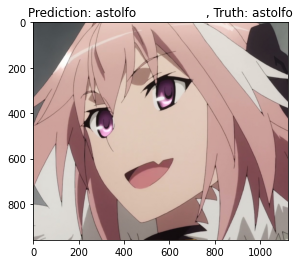

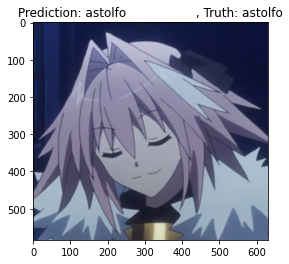

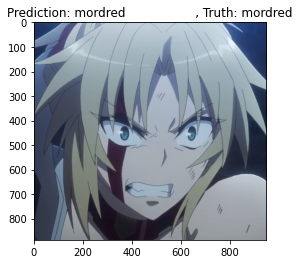

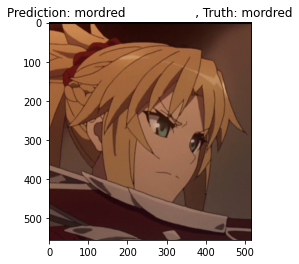

In [31]:
best_model = models['RF']

modeling_data_path = os.path.join('data_set', 'modeling_data')
characters_folders = os.listdir(modeling_data_path)
for character in characters_folders:
    pic_folder = os.path.join(modeling_data_path, character)
    all_pics = os.listdir(pic_folder)
    sampling = random.choices(all_pics, k=2)
    for pic in sampling:
        pic_dir = os.path.join(pic_folder, pic)
        image = cv2.imread(pic_dir)
        display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic_feature = loader.extract_single_image(pic_dir)
        pic_feature = normalizer.transform(np.array([pic_feature]))
        # print(pic_feature.shape)
        pred_result = best_model.predict(pic_feature)[0]
        pred_result = name_label_map[pred_result]
        # print(pred_result)
        plt.imshow(display_image)
        plt.title("Prediction: {}, Truth: {}".format(pred_result, character))
        plt.show()

### Confusion Matrix

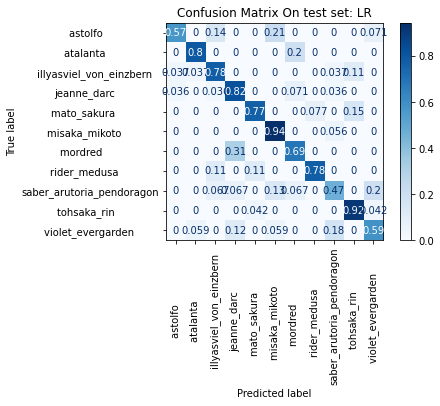

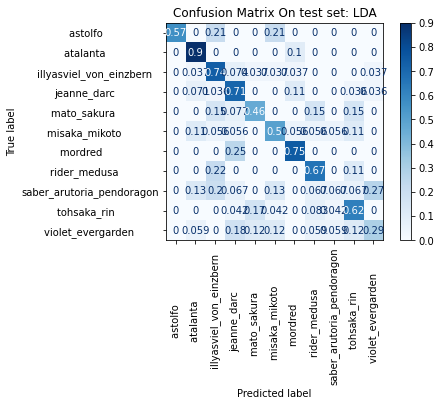

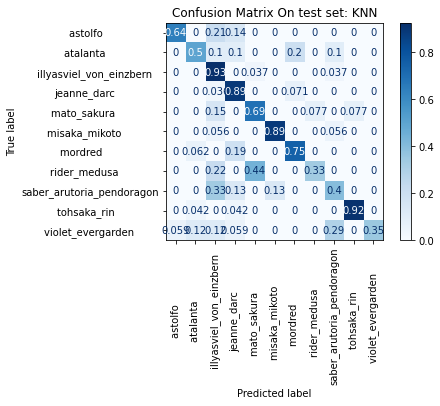

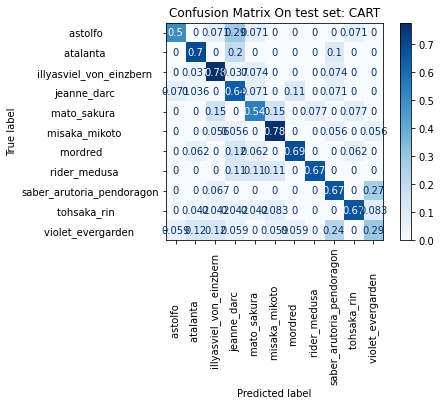

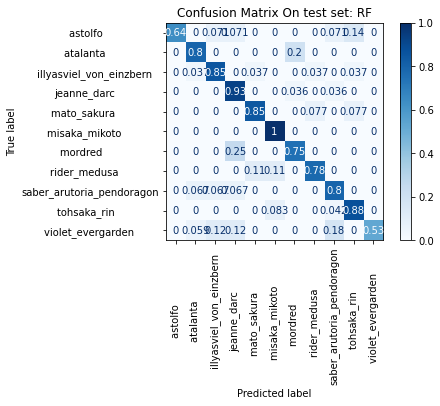

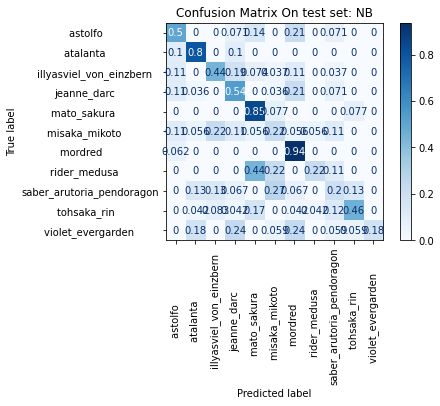

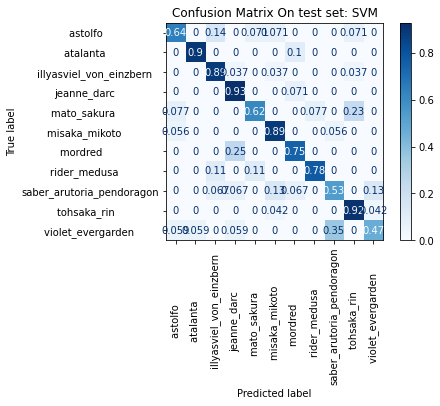

In [32]:
for key in models.keys():
    model = models[key]
    disp = plot_confusion_matrix(model, fv_tst, fv_l_tst,
                                 display_labels=name_label_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.xticks(rotation='vertical', horizontalalignment="center")
    disp.ax_.set_title("Confusion Matrix On test set: {}".format(key))
    plt.show()

## Training on whole Dataset

### Warning: code blocks below may take a long time / large memory to run.

Since code blocks below will run models on the whole dataset, python kernel may be killed due to lack of memory when running memory heavy models like random-forest classifier. These code blocks are here for testing final prediction result.


### switching and reencode the dataset

In [31]:
data_cleaning(True, True, destination="whole_data", force_write=True)

[STATUS] copying pics in data_set\moeimouto-faces-filtered\000_hatsune_miku to data_set\testing_data\hatsune_miku
[STATUS] 000_hatsune_miku copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\001_kinomoto_sakura to data_set\testing_data\kinomoto_sakura
[STATUS] 001_kinomoto_sakura copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\002_suzumiya_haruhi to data_set\testing_data\suzumiya_haruhi
[STATUS] 002_suzumiya_haruhi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\003_fate_testarossa to data_set\testing_data\fate_testarossa
[STATUS] 003_fate_testarossa copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\004_takamachi_nanoha to data_set\testing_data\takamachi_nanoha
[STATUS] 004_takamachi_nanoha copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\006_akiyama_mio to data_set\testing_data\akiyama_mio
[STATUS] 006_akiyama_mio copy work finished
[STATUS] c

[STATUS] 056_nagi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\058_kochiya_sanae to data_set\testing_data\kochiya_sanae
[STATUS] 058_kochiya_sanae copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\059_sairenji_haruna to data_set\testing_data\sairenji_haruna
[STATUS] 059_sairenji_haruna copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\060_ichinose_kotomi to data_set\testing_data\ichinose_kotomi
[STATUS] 060_ichinose_kotomi copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\061_furude_rika to data_set\testing_data\furude_rika
[STATUS] 061_furude_rika copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\062_matou_sakura to data_set\testing_data\matou_sakura
[STATUS] 062_matou_sakura copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\063_ryuuguu_rena to data_set\testing_data\ryuuguu_rena
[STATUS] 063_ryuuguu_rena copy work 

[STATUS] 123_midori copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\129_primula to data_set\testing_data\primula
[STATUS] 129_primula copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\131_belldandy to data_set\testing_data\belldandy
[STATUS] 131_belldandy copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\132_minamoto_chizuru to data_set\testing_data\minamoto_chizuru
[STATUS] 132_minamoto_chizuru copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\134_nunnally_lamperouge to data_set\testing_data\nunnally_lamperouge
[STATUS] 134_nunnally_lamperouge copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\136_shirley_fenette to data_set\testing_data\shirley_fenette
[STATUS] 136_shirley_fenette copy work finished
[STATUS] copying pics in data_set\moeimouto-faces-filtered\137_sonsaku_hakufu to data_set\testing_data\sonsaku_hakufu
[STATUS] 137_sonsaku_hakufu co

[STATUS] 004_0_illyasviel_von_einzbern_official copy work finished
[STATUS] copying pics in data_set\self-collected\005_0_rider_medusa_official to data_set\testing_data\rider_medusa
[STATUS] 005_0_rider_medusa_official copy work finished
[STATUS] copying pics in data_set\self-collected\006_0_misaka_mikoto_official to data_set\testing_data\misaka_mikoto
[STATUS] 006_0_misaka_mikoto_official copy work finished
[STATUS] copying pics in data_set\self-collected\007_0_violet_evergarden_official to data_set\testing_data\violet_evergarden
[STATUS] 007_0_violet_evergarden_official copy work finished
[STATUS] copying pics in data_set\self-collected\001_1_saber_arutoria_pendoragon_doujin to data_set\testing_data\saber_arutoria_pendoragon
[STATUS] 001_1_saber_arutoria_pendoragon_doujin copy work finished
[STATUS] copying pics in data_set\self-collected\002_1_tohsaka_rin_doujin to data_set\testing_data\tohsaka_rin
[STATUS] 002_1_tohsaka_rin_doujin copy work finished
[STATUS] copying pics in data_se

In [32]:
loader = FeatureExtractionDataLoader(data_path='data_set/whole_data')
loader.write_data(file_name='tf_l_dataset.mat', rgb=False)

[STATUS] Characters including ['aika_granzchesta', 'aisaka_taiga', 'akihime_sumomo', 'akiyama_mio', 'akizuki_ritsuko', 'alice_margatroid', 'amami_haruka', 'ana_coppola', 'andou_mahoro', 'arcueid_brunestud', 'asagiri_mai', 'asahina_mikuru', 'asakura_otome', 'asakura_yume', 'ayanami_rei', 'ayasaki_hayate', 'belldandy', 'black_rock_shooter', 'c.c', 'canal_volphied', 'caro_ru_lushe', 'chii', 'cirno', 'corticarte_apa_lagranges', 'daidouji_tomoyo', 'enma_ai', 'fate_testarossa', 'feena_fam_earthlight', 'flandre_scarlet', 'fujibayashi_kyou', 'fukuzawa_yumi', 'furude_rika', 'furukawa_nagisa', 'fuyou_kaede', 'golden_darkness', 'hakurei_reimu', 'hatsune_miku', 'hayama_mizuki', 'hayase_mitsuki', 'hiiragi_kagami', 'hiiragi_tsukasa', 'hinamori_amu', 'hirasawa_yui', 'horo', 'houjou_reika', 'houjou_satoko', 'ibuki_fuuko', 'ichinose_kotomi', 'illyasviel_von_einzbern', 'ito_chika', 'ito_nobue', 'izayoi_sakuya', 'izumi_konata', 'kagamine_rin', 'kagurazaka_asuna', 'kallen_stadtfeld', 'kamikita_komari', 'k

[STATUS] 114/162 processing folder: rider_medusa
[STATUS] 115/162 processing folder: ryougi_shiki
[STATUS] 116/162 processing folder: ryuuguu_rena
[STATUS] 117/162 processing folder: saber_arutoria_pendoragon
[STATUS] 118/162 processing folder: saigyouji_yuyuko
[STATUS] 119/162 processing folder: sairenji_haruna
[STATUS] 120/162 processing folder: sakagami_tomoyo
[STATUS] 121/162 processing folder: sanzenin_nagi
[STATUS] 122/162 processing folder: saotome_alto
[STATUS] 123/162 processing folder: sendou_erika
[STATUS] 124/162 processing folder: seto_san
[STATUS] 125/162 processing folder: shameimaru_aya
[STATUS] 126/162 processing folder: shana
[STATUS] 127/162 processing folder: sheryl_nome
[STATUS] 128/162 processing folder: shidou_hikaru
[STATUS] 129/162 processing folder: shigure_asa
[STATUS] 130/162 processing folder: shihou_matsuri
[STATUS] 131/162 processing folder: shindou_chihiro
[STATUS] 132/162 processing folder: shindou_kei
[STATUS] 133/162 processing folder: shinku
[STATUS]

### load data

In [33]:
data = sio.loadmat(os.path.join('data_set', 'tf_l_dataset.mat'))

### normalize data

In [34]:
normalizer = MinMaxScaler(feature_range=(0, 1))
img_feature = normalizer.fit_transform(data['image_feature'])
name_label_map = data['names']
print("[STATUS] feature vector normalized.")

[STATUS] feature vector normalized.


In [35]:
fv_trn, fv_tst, fv_l_trn, fv_l_tst = train_test_split(img_feature,
                                                      data['labels'][0],
                                                      test_size=test_size,
                                                      random_state=seed)
print("[STATUS] split train and test data.")
print("Train data   : {}".format(fv_trn.shape))
print("Test data    : {}".format(fv_tst.shape))
print("Train labels : {}".format(fv_l_trn.shape))
print("Test labels  : {}".format(fv_l_tst.shape))

[STATUS] split train and test data.
Train data   : (11729, 532)
Test data    : (2070, 532)
Train labels : (11729,)
Test labels  : (2070,)


In [36]:
# Logistic Regreession
lr_c = 6.8
# Knn
knn_k = 4
# rf
num_trees = 1400
# svm
svm_c = 13.
svm_degree = 4

In [38]:
models = {'LR': LogisticRegression(max_iter=1000, random_state=seed, tol=0.0001, C=lr_c, warm_start=True),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(n_neighbors = knn_k),
          'CART': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_estimators=num_trees, random_state=seed, criterion='gini', warm_start=True),
          'NB': GaussianNB(),
          'SVM': SVC(random_state=seed, kernel='poly', C=svm_c, degree=svm_degree)}

In [ ]:
for key in models.keys():
    since = time.time()
    model = models[key]
    model.fit(fv_trn, fv_l_trn)
    pred = model.predict(fv_trn)
    result = np.equal(pred, fv_l_trn)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on training set: {:.03f}".format(key, accuracy))
    pred = model.predict(fv_tst)
    result = np.equal(pred, fv_l_tst)
    accuracy = np.sum(result) / len(result)
    print("[RESULT] {} accuracy on testing set: {:.03f}".format(key, accuracy))
    time_elapsed = time.time() - since
    print('[TIME_CONSUMPTION] Finishing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[RESULT] LR accuracy on training set: 0.456
[RESULT] LR accuracy on testing set: 0.335
[TIME_CONSUMPTION] Finishing in 0m 38s
[RESULT] LDA accuracy on training set: 0.422
[RESULT] LDA accuracy on testing set: 0.282
[TIME_CONSUMPTION] Finishing in 0m 1s
[RESULT] KNN accuracy on training set: 0.454
[RESULT] KNN accuracy on testing set: 0.269
[TIME_CONSUMPTION] Finishing in 1m 56s
[RESULT] CART accuracy on training set: 0.998
[RESULT] CART accuracy on testing set: 0.218
[TIME_CONSUMPTION] Finishing in 0m 9s
[RESULT] RF accuracy on training set: 0.998
[RESULT] RF accuracy on testing set: 0.551
[TIME_CONSUMPTION] Finishing in 5m 8s
[RESULT] NB accuracy on training set: 0.393
[RESULT] NB accuracy on testing set: 0.132
[TIME_CONSUMPTION] Finishing in 0m 13s
